# Example use of domus-mlsim

This python notebook shows how to run the HVAC, DV0 and DV1 simulators together with a sample controller (SimpleHvac).

The notebook assumes that the current directory (where you started `jupyter notebook` from) is within the `domus_mlsim` folder (as checked out from https://github.com/jbrusey/domus_mlsim). 

The first step is to import various definitions, create a controller, and load the simulator models. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import sys
import pandas as pd
import joblib
import numpy as np
import seaborn as sns

sns.set_theme()

from domus_mlsim import (HVAC_UT_COLUMNS,
                        HVAC_XT_COLUMNS,
                        DV0_UT_COLUMNS,
                        DV0_XT_COLUMNS,
                        DV1_UT_COLUMNS,
                        DV1_XT_COLUMNS,
                        HvacUt,
                        HvacXt,
                        DV0Ut,
                        DV0Xt,
                        DV1Ut,
                        DV1Xt,
                        SimpleHvac,
                        kw_to_array,
                        MLSim,
                        KELVIN,
                        run_dv0_sim,
                        run_dv1_sim,
                        load_dv0,
                        load_dv1,
                        load_hvac,
                        )


dv0_scalar_and_model = load_dv0()
dv1_scalar_and_model = load_dv1()
hvac_scalar_and_model = load_hvac()
controller = SimpleHvac()

We define a `plot_results` function to make it easy to plot the most important variables. Alter this to add other variables or reformat the plots.

In [2]:
def plot_results(cabin, hvac, ctrl):
    cabdf = pd.DataFrame(cabin, columns=DV0_XT_COLUMNS)
    ax = cabdf.plot(y=['t_drvr1', 't_drvr2', 't_drvr3', 'ws'],)
    ax.set(xlabel='Time (s)', ylabel='Temperature (K)')

    ax = cabdf.plot(y=['v_drvr1', 'v_drvr2', 'v_drvr3'], )
    ax.set(xlabel='Time (s)', ylabel='Air velocity (m/s)')
    hvacdf = pd.DataFrame(hvac, columns=HVAC_XT_COLUMNS)
    ax = hvacdf.plot(y=HVAC_XT_COLUMNS, subplots=True,  figsize=(6,6))
    ax[0].set(xlabel='Time (s)', ylabel='Humidity')
    ax[1].set(xlabel='Time (s)', ylabel='Flow (m3/h)')
    ax[2].set(xlabel='Time (s)', ylabel='Temperature (K)')
    ax = pd.DataFrame(ctrl, columns=SimpleHvac.XT_COLUMNS).plot(
        y=SimpleHvac.XT_COLUMNS, subplots=True, figsize=(6, 10))
    ax[0].set(ylabel='Power (W)')
    ax[1].set(ylabel='Power (W)')
    ax[2].set(ylabel='Power (W)')
    ax[3].set(ylabel='Power (W)')
    ax[4].set(ylabel='Setting', ylim=(-0.1,1.1))
    ax[5].set(ylabel='Setting', ylim=(-0.1,1.1))


## DV0

We can now run a DV0 simulation (that includes simulating the HVAC and running the controller). 

Two examples are tried - warming up from $-1$ degC and cooling down from $37$ degC.

Note that although the controller tries to use window heating, the DV0 variant ignores this.

### Warm up from ambient $-1$ C

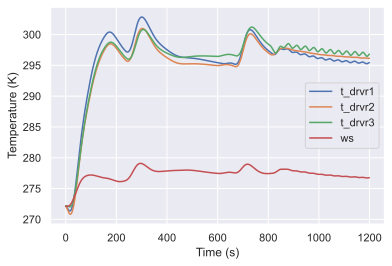

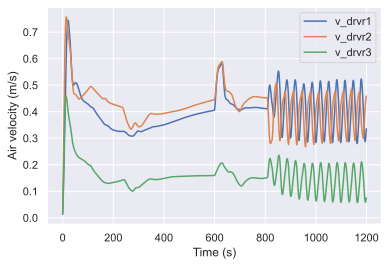

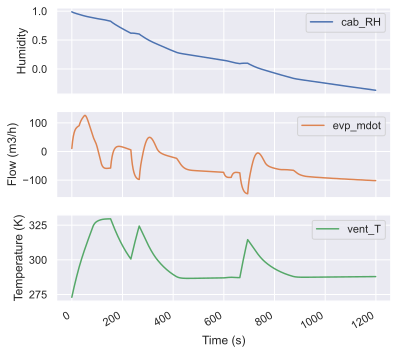

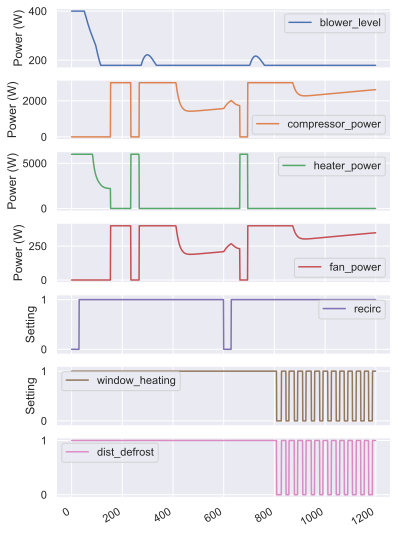

In [3]:
cabin, hvac, ctrl = run_dv0_sim(dv0_scalar_and_model,
                                hvac_scalar_and_model,
                                controller,
                                setpoint=KELVIN + 22,
                                n=1200,
                                ambient_t=KELVIN + 1,
                                ambient_rh=0.99,
                                cabin_t=KELVIN - 1,
                                cabin_v=0,
                                cabin_rh=0.99,
                                solar1=100,
                                solar2=50,
                                car_speed=100)

plot_results(cabin, hvac, ctrl)

### Cool down from 37C

The following example shows what happens when cooling. Note that cooling is not performed completely and this may reflect a fault or limitation in the DV0 simulation (it does not occur for DV1). 

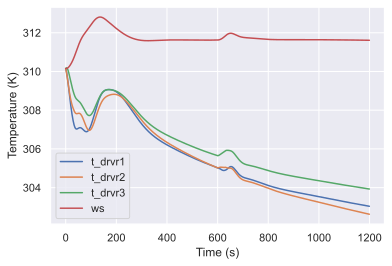

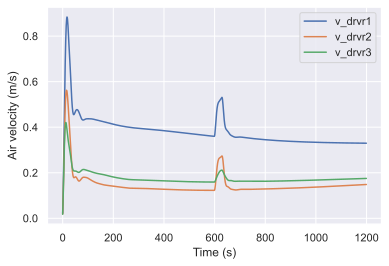

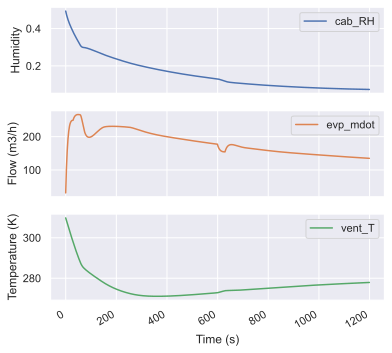

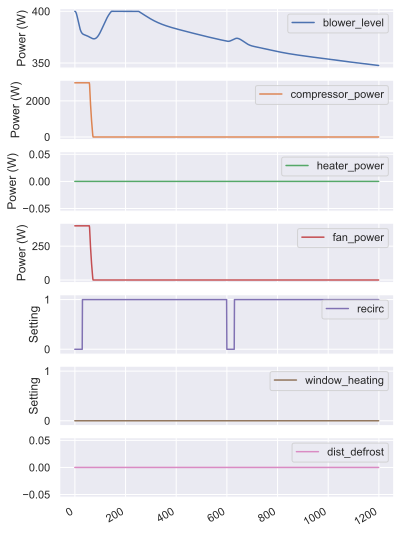

In [4]:
cabin, hvac, ctrl = run_dv0_sim(dv0_scalar_and_model, 
                                hvac_scalar_and_model,
                                controller,
                                setpoint=KELVIN + 22,
                                n=1200,
                                ambient_t=KELVIN + 37,
                                ambient_rh=0.99,
                                cabin_t=KELVIN + 37,
                                cabin_v=0,
                                cabin_rh=0.50,
                                solar1=300,
                                solar2=150,
                                car_speed=30)

plot_results(cabin, hvac, ctrl)

## DV1
### Warm up from -1C

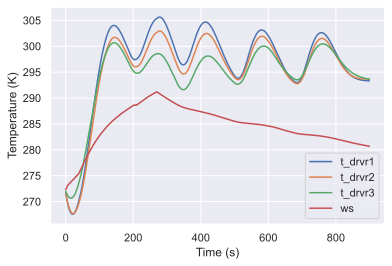

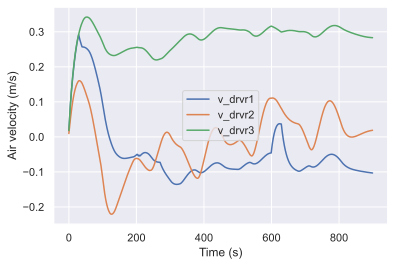

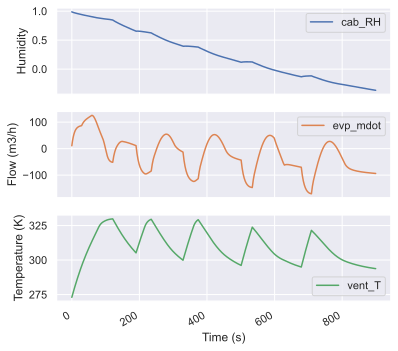

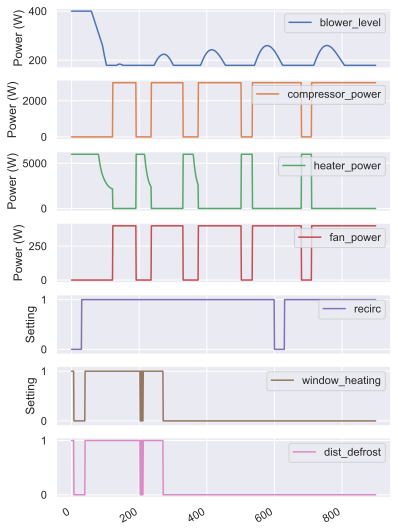

In [5]:
cabin, hvac, ctrl, b_u, h_u, c_u  = run_dv1_sim(dv1_scalar_and_model, 
                                hvac_scalar_and_model,
                                
                                controller,
                                setpoint=KELVIN + 22,
                                n=900,
                                ambient_t=KELVIN - 1,
                                ambient_rh=0.99,
                                cabin_t=KELVIN - 1,
                                cabin_v=0,
                                cabin_rh=0.99,
                                solar1=100,
                                solar2=50,
                                car_speed=0, log_inputs=True)

plot_results(cabin, hvac, ctrl)

### Cool down from 37C

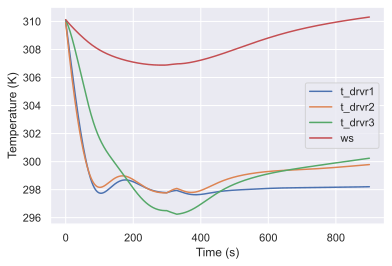

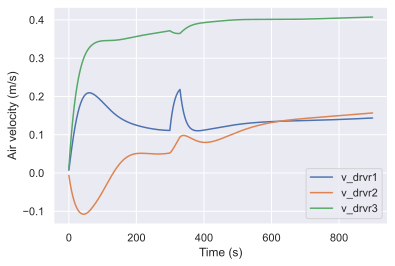

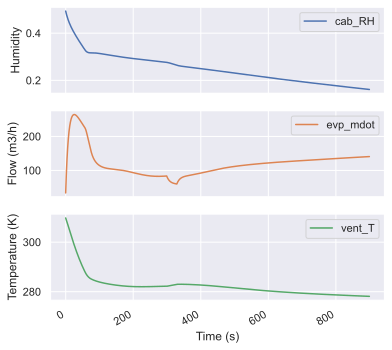

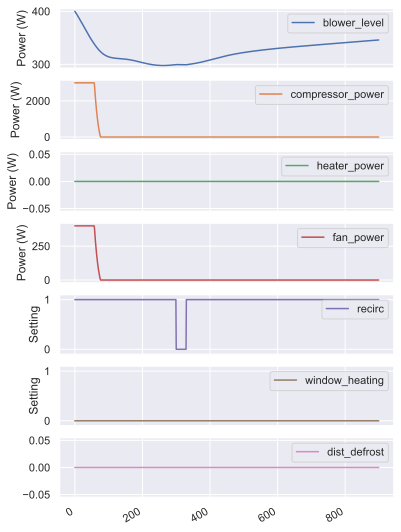

In [6]:
cabin, hvac, ctrl, b_u, h_u, c_u = run_dv1_sim(dv1_scalar_and_model, 
                                hvac_scalar_and_model,
                                controller,
                                setpoint=KELVIN + 22,
                                n=900,
                                ambient_t=KELVIN + 37,
                                ambient_rh=0.99,
                                cabin_t=KELVIN + 37,
                                cabin_v=0,
                                cabin_rh=0.50,
                                solar1=300,
                                solar2=150,
                                car_speed=30, log_inputs=True)

plot_results(cabin, hvac, ctrl)